<a href="https://colab.research.google.com/github/christian235711/covid/blob/main/preprocessing_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xlrd
from sklearn.model_selection import train_test_split


from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

- Le travail est divisé en plusieurs parties. Tout d'abord, la base de données est traitée afin d'éliminer les variables inutiles comme à l'étape du data exploraroty. Donc, nous récopions les lignes de code clés.

- Ensuite, les données sont divisées en deux échantillons (apprentissage et test)

- Le premier preprocessing (à l'aide de la fonction *preprocessing*) appliqué sur le dataset : encondent les variables qualitatives en 0 ou 1, éliminent les patients ayant au moins une caractéristique manquante (quatitatives et qualitatives) et divise chacune de deux échantillons en deux groupes (la varibles cible et les variables explicatives). 

- A la suite de cette étape, le premier modèle utilisé font appel aux arbres de décision (*DecisionTreeClassifier*) pour obtenir les premiers aperçus de la prédiction des données. Afin de mieux visualiser les resulats, les outils choisis sont la métrique f1-score, le matrice de confusion, le rapport de classification ainsi que les courbes d'apprentissages (issus de sklearn.metrics et sklearn.model_selection). Chacun de ses éléments sont dans la fonction *evaluation*. 
- Les resultats du premier modèle sont assez satisfaisants:
  - 96% des patients sains sont prédits correctement contre 17% des patients covid prédits correctement. 
  - 84% des patients prédits sains sont bien classés par opposition à 50% des patients prédits covid mal classés.
  - le score f1 montre également une disproportion des valeurs.

  - les courbes d'apprentissage nous montrent que le modèle est en overfitting.
- L'autre algorithme utilisé est le Random forest qui va lutter contre l'overfitting. 
- Il est également envisagé de travailler uniquement avec les variables sanguines, de créer une nouvelle variable *maladie* contenant les patients sains et les patients ayant au moins une maladie, de sélectionner les variables les plus importantes lors de la création d'un arbre de décision et d'utiliser des transformers. Certaines de ces idées sont prometteuses mais on ne les commentera pas car le but est de chercher un ensemble des données (création d'une nouvelle variable, élimination des valeurs manquantes) avec lesquels travailler lors de la modélisation et de répéter les modèles de machine learning les plus adaptés à la situation.









In [3]:
data_orig = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/covid/dataset_covid.xlsx")

data= data_orig.copy()

In [4]:
data.shape

(5644, 111)

In [5]:
# création d'une nouvelle base de données (reprise des caractéristiques sanguines et maladies virales que nous avons troouvé à l'étape su data exploratory)

# Eliminer les colonnes inutiles
data=data.loc[:, data.isna().sum()/data.shape[0] <.9 ] # ou data[  data.columns[data.isna().sum()/data.shape[0] < .9]  ]
data = data.drop(['Influenza A, rapid test', 'Influenza B, rapid test',],axis=1)

# création de deux groupes de variables
val = (data.isna().sum()/data.shape[0])*100
maladie_col = data.columns[(val > 76) & (val < 86)]
sang_col = data.columns[val > 86]
print("maladies : "+str(maladie_col))
print("sang : "+ str(sang_col))

maladies : Index(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2'],
      dtype='object')
sang : Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')


In [6]:
key_col = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [7]:
data = data[ key_col + list(sang_col) +  list(maladie_col)]
data

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# train set et test set
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

In [9]:
train_set['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [10]:
test_set['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [11]:
# Encodage
def encodage(x):
  for i in x.select_dtypes('object') :
   x.loc[:,i] = x[i].map( {"positive":1, "negative":0, "detected":1, "not_detected":0} )
  #x.loc[:,"SARS-Cov-2 exam result"] = x["SARS-Cov-2 exam result"].map( {"positive":1, "negative":0} )
  return x


In [12]:
def feature_engineering(x):
  x['maladie']= x.loc[:, maladie_col].sum(axis=1) >=1
  x = x.drop(maladie_col, axis =1)
  return x

In [13]:
# Imputation
def imputation(x):
  return x.dropna(axis=0)

In [14]:
# preprocessing
def preprocessing(x):
  x= encodage(x)
  x= imputation(x)

  y = x["SARS-Cov-2 exam result"] 
  W = x.drop("SARS-Cov-2 exam result", axis = 1)

  print(y.value_counts())
  return W, y

In [15]:
# preprocessing
def preprocessing_feature_engineering(x):
  x= encodage(x)
  x= feature_engineering(x)
  x= imputation(x)

  y = x["SARS-Cov-2 exam result"] 
  W = x.drop("SARS-Cov-2 exam result", axis = 1)

  print(y.value_counts())
  return W, y

In [16]:

X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)


0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [17]:
# Modélisation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif # SelectKbest pour sélectionner les k meilleures variables à l'aide d'une fonction et f_classif pour faire un test d'anova
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

model_1 = DecisionTreeClassifier(random_state=0) # random_state pour fixer les valeurs aléatoires
model_2 = RandomForestClassifier(random_state =0)

#model_p_v1 = make_pipeline(SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0)) # plusieurs modèles en fonction de k
#model_p_v2 = make_pipeline(PolynomialFeatures(2) , SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0))


In [18]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# f1-score pour visualiser le rapport entre le précision et la sensibilité (recall). Ces sont des métriques qui nous permet de déterminer l'erreur de type I et l'erreur de type II.
# learning_curve pour voir si on est en underfitting ou overfitting



In [19]:
def evaluation(model):

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred)) 

  print(classification_report(y_train,model.predict(X_train) ))

  N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring = 'f1', train_sizes = np.linspace(0.1, 1, 10) )

  plt.figure(figsize = (10,6))
  plt.plot(N, train_score.mean(axis=1), label ="train_score")
  plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

  plt.legend()


[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       258
           1       1.00      1.00      1.00        38

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296



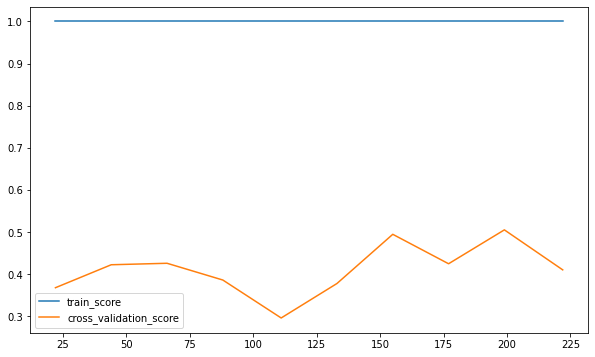

In [20]:
evaluation(model_1)

                                                         0
Leukocytes                                        0.222302
Platelets                                         0.161302
Red blood Cells                                   0.140046
Influenza B                                       0.078269
Eosinophils                                       0.065086
Red blood cell distribution width (RDW)           0.059761
Mean corpuscular hemoglobin concentration (MCHC)  0.047603
Inf A H1N1 2009                                   0.046836
Mean platelet volume                              0.033966
Metapneumovirus                                   0.028879
Mean corpuscular volume (MCV)                     0.028179
Mean corpuscular hemoglobin (MCH)                 0.026472
Basophils                                         0.024153
Rhinovirus/Enterovirus                            0.020128
Hematocrit                                        0.007749
Monocytes                                         0.0050

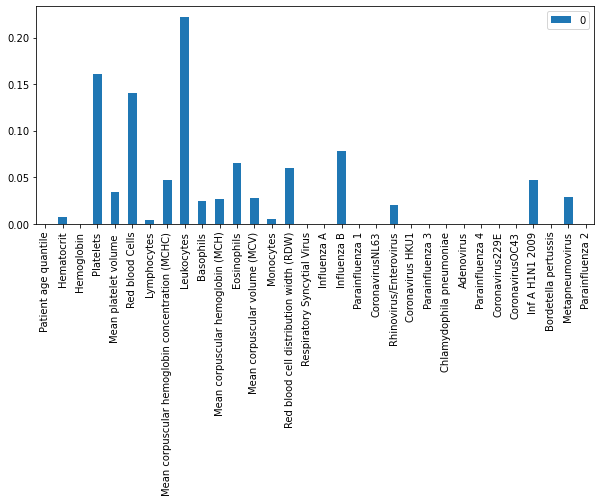

In [21]:
 # features selection
print(pd.DataFrame(model_1.feature_importances_, index = X_train.columns).sort_values(0, ascending =False ) )
pd.DataFrame(model_1.feature_importances_, index = X_train.columns).plot.bar(figsize=(10,4) )


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

    accuracy                           0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



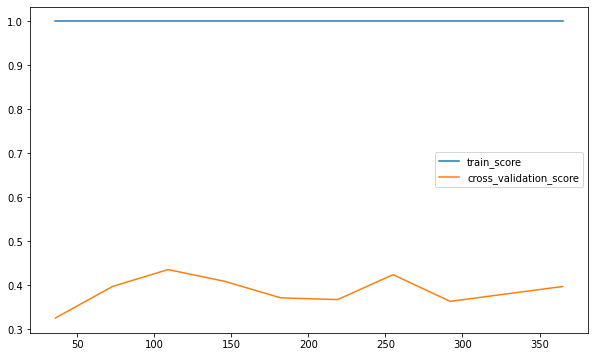

In [22]:
# ARBRES DE DECISION SUR DATA_1
# nouvelle base de données contenant les caractéristiques sanguines
data_2 = data[ key_col + list(sang_col)]

# train set et test set
train_set, test_set = train_test_split(data_2, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)
#evaluation
evaluation(model_1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

    accuracy                           0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



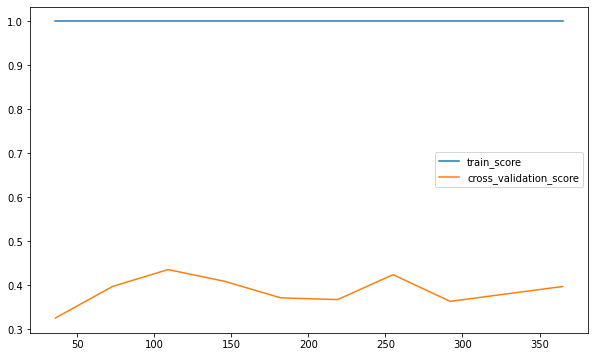

In [23]:
# ARBRES DE DECISION SUR DATA_2
# train set et test set
train_set, test_set = train_test_split(data_2, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train =preprocessing(train_set)
X_test, y_test =preprocessing(test_set)
#evaluation
evaluation(model_1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[94  1]
 [14  2]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        95
           1       0.67      0.12      0.21        16

    accuracy                           0.86       111
   macro avg       0.77      0.56      0.57       111
weighted avg       0.84      0.86      0.82       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



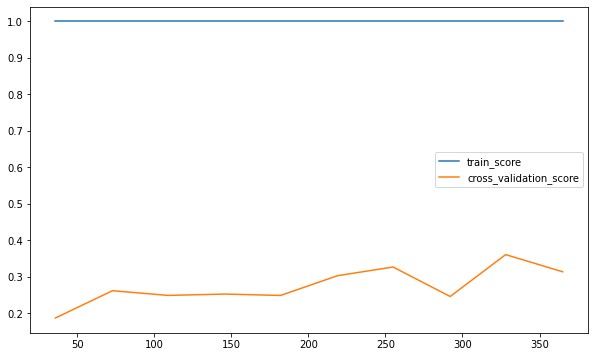

In [24]:
# RANDOM FOREST
# train set et test set
train_set, test_set = train_test_split(data_2, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train =preprocessing(train_set)
X_test, y_test =preprocessing(test_set)
#evaluation

evaluation(model_2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



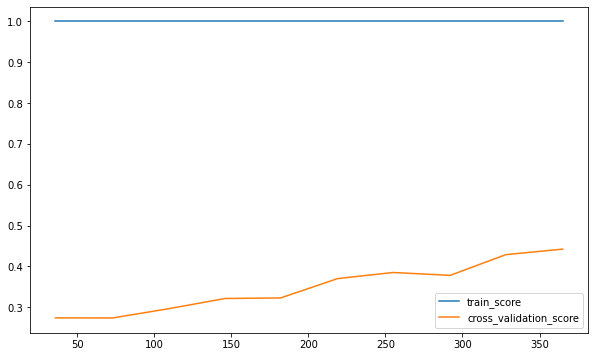

In [31]:
# RANDOM FOREST
# train set et test set
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train =preprocessing_feature_engineering(train_set)
X_test, y_test =preprocessing_feature_engineering(test_set)
#evaluation
evaluation(model_2)

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



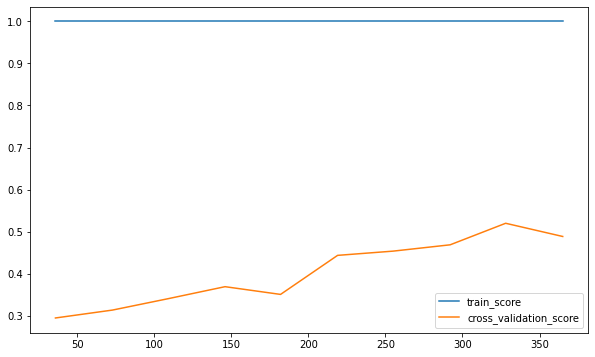

In [26]:
#
model_p = make_pipeline(SelectKBest(f_classif, k = 10), RandomForestClassifier(random_state=0))
evaluation(model_p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



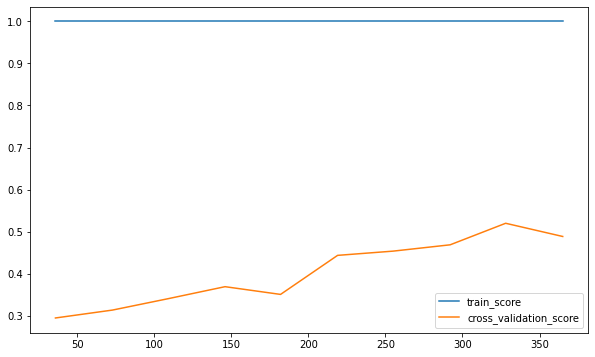

In [39]:
# RANDOM FOREST
# train set et test set
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train =preprocessing_feature_engineering(train_set)
X_test, y_test =preprocessing_feature_engineering(test_set)
#evaluation
model_p_v0 = make_pipeline(SelectKBest(f_classif, k = 5), RandomForestClassifier(random_state=0))
evaluation(model_p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[93  2]
 [12  4]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        95
           1       0.67      0.25      0.36        16

    accuracy                           0.87       111
   macro avg       0.78      0.61      0.65       111
weighted avg       0.85      0.87      0.85       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



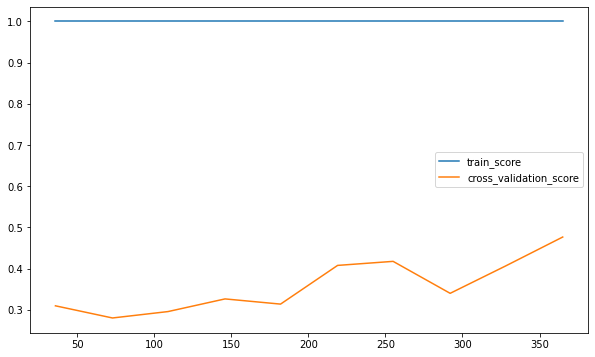

In [41]:
# RANDOM FOREST
# train set et test set
train_set, test_set = train_test_split(data_2, test_size = 0.2, random_state=0 )
#preprocessing
X_train, y_train =preprocessing(train_set)
X_test, y_test =preprocessing(test_set)
#evaluation
model_p_v0 = make_pipeline(SelectKBest(f_classif, k = 5), RandomForestClassifier(random_state=0))
evaluation(model_p)

[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



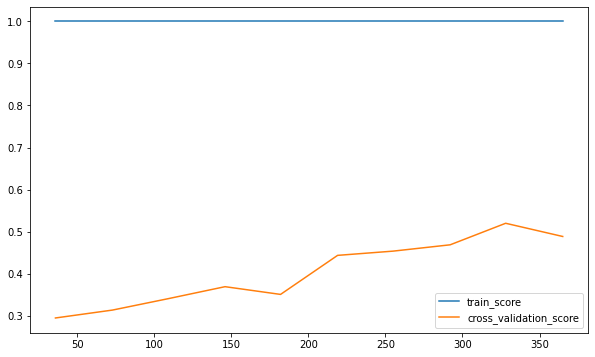

In [28]:
model_p_v1 = make_pipeline(SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0))
evaluation(model_p)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[91  4]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.60      0.38      0.46        16

    accuracy                           0.87       111
   macro avg       0.75      0.67      0.70       111
weighted avg       0.86      0.87      0.86       111

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00        65

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn

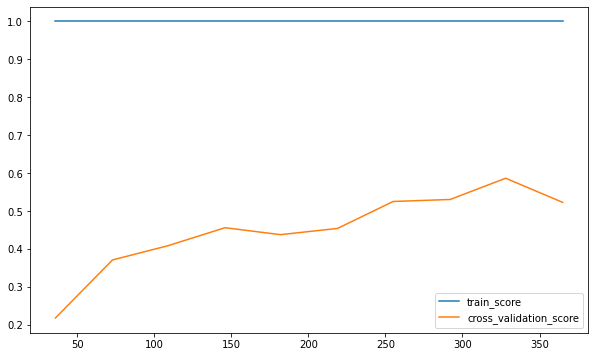

In [29]:
model_p_v2 = make_pipeline(PolynomialFeatures(2) , SelectKBest(f_classif, k = 8), RandomForestClassifier(random_state=0))
evaluation(model_p_v2)

In [33]:
model_p_v1.set_params

<bound method Pipeline.set_params of Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=8,
                             score_func=<function f_classif at 0x7f364d8f08c0>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                   

In [36]:
RandomForestClassifier.set_params

<function sklearn.base.BaseEstimator.set_params>